Model: "ode"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 143
Trainable params: 143
Non-trainable params: 0
_________________________________________________________________


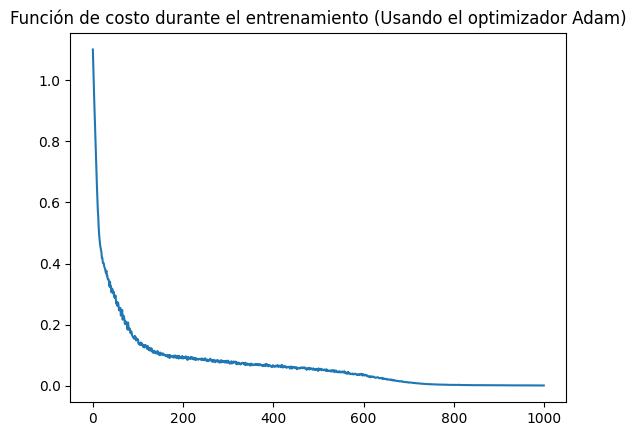

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam

import matplotlib.pyplot as plt
import numpy as np

"""
Creación del modelo para resolver una EDO a partir de un modelo de red ya 
creado. Se usará como herencia para este caso y no empezar a construir el 
modelo desde cero.
"""

class ODE(Sequential):
    # **kwargs significa "any extra keyword arguments"
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name = "loss")
        self.mse = tf.keras.losses.MeanSquaredError()
        
    @property 
    def metrics(self):
        return [self.loss_tracker]
    
    def train_step(self, data):
        batch = tf.shape(data)[0]
        min = tf.cast(tf.reduce_min(data),tf.float32)
        max = tf.cast(tf.reduce_max(data), tf.float32)
        x = tf.random.uniform((batch, 1), minval = min, maxval = max)
        
        with tf.GradientTape() as tape: 
            with tf.GradientTape() as tape2: 
                tape2.watch(x) #d²y/dx²
                
                with tf.GradientTape() as tape3:
                    tape3.watch(x) #dy/dx
                    y = self(x, training = True)
            
                dy = tape3.gradient(y,x) # Se calcula el cambio de y respecto a x
            d_dy = tape2.gradient(dy,x) # Se calcula la segunda derivada de y respecto a x
            
            x_0 = tf.zeros(batch, 1) # Tensor cuyas entradas son cero y corresponden a los valores
            # en los que se se calcula la condición inicial de y e y'
                
            with tf.GradientTape() as tape_initial:
                tape_initial.watch(x_0) # Verá el cambio de la condición inicial y_0 respecto a x_0
                y_0 = tf.cast(self(x_0, training = True), tf.float32) 
                # Tensor cuyas entradas posteriormente se utilizarán para indicar los valores
                # iniciales de y_0 en x=0.
                    
            dy_0 = tape_initial.gradient(y_0,x_0) # Corresponde a dy/dx evaluado en x=0. Es decir, la condición inicial.
            
            eq = d_dy + y # Ecuación diferencial que se desea resolver
                
            initial_condition_y = 1. # Valor de y(0)
            initial_condition_dy  = -0.5 # Valor de y'(0)
            
            loss = self.mse(0., eq) + self.mse(y_0, initial_condition_y) + self.mse(dy_0, initial_condition_dy)
            
        grads = tape.gradient(loss, self.trainable_variables) # Se aplica el gradiente para el entrenamiento
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables)) 
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
model = ODE()
model.add(Dense(10, activation = 'tanh', input_shape=(1,)))
model.add(Dense(10, activation = 'tanh'))
model.add(Dense(1, activation = 'tanh'))
model.add(Dense(1))

model.summary()  

model.compile(optimizer=Adam(learning_rate=1e-3))

x = tf.linspace(-5, 5, 1000)
history = model.fit(x, epochs=1000, batch_size=200, verbose=0)

plt.plot(history.history["loss"])
plt.title("Función de costo durante el entrenamiento (Usando el optimizador Adam)")
plt.show()

4/4 [==============================] - 0s 927us/step


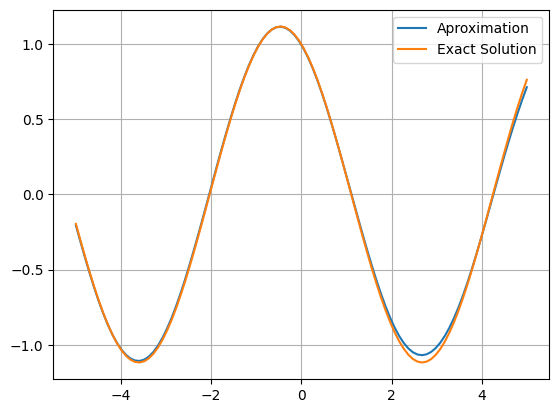

In [2]:
x_test = tf.linspace(-5, 5, 100)
predict = model.predict(x_test)

plt.plot(x_test, predict, label = "Aproximation")
plt.plot(x_test, (np.cos(x_test) -0.5*np.sin(x_test)), label = "Exact Solution")
plt.grid()
plt.legend()
plt.show()

Model: "ode_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                20        
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
 dense_7 (Dense)             (None, 1)                 2         
                                                                 
Total params: 143
Trainable params: 143
Non-trainable params: 0
_________________________________________________________________


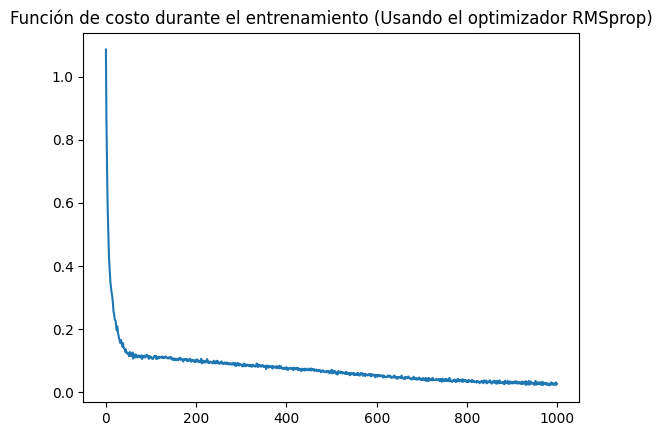

4/4 [==============================] - 0s 968us/step


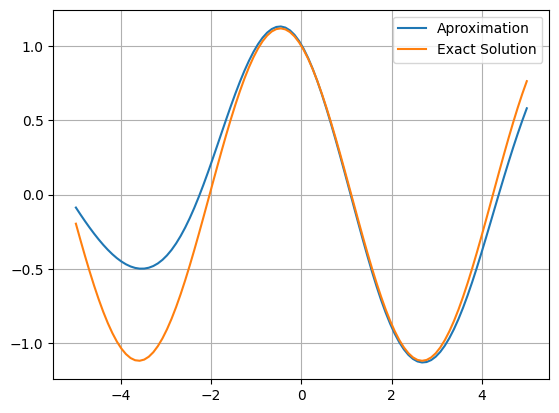

In [3]:
model2 = ODE()

model2.add(Dense(10, activation = 'tanh', input_shape=(1,)))
model2.add(Dense(10, activation = 'tanh'))
model2.add(Dense(1, activation = 'tanh'))
model2.add(Dense(1))

model2.summary()  
model2.compile(optimizer = RMSprop(learning_rate=1e-3), metrics = ['loss'])

history2 = model2.fit(x, epochs=1000, batch_size=200, verbose=0)

plt.plot(history2.history["loss"])
plt.title("Función de costo durante el entrenamiento (Usando el optimizador RMSprop)")
plt.show()

y = model2.predict(x_test)

plt.plot(x_test, y, label = "Aproximation")
plt.plot(x_test, (np.cos(x_test) -0.5*np.sin(x_test)), label = "Exact Solution")
plt.grid()
plt.legend()
plt.show()